# Productivity Classification NotebookThis notebook loads data and prepares a productivity classification workflow.

In [12]:
# reading data on google drive
from google.colab import drive
# Mount your Google Drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

# Load CSV file from Google Drive
file_path = '/content/drive/MyDrive/other/data/Data for MSC Thesis/eth_householdgeovariables_y5.csv'
df = pd.read_csv(file_path)

print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        household_id  dist_road  dist_market  dist_border  dist_popcenter  \
0  20101010100104011        7.7   162.300003    82.900002             0.4   
1  20101010100104022        7.7   162.300003    82.900002             0.4   
2  20101010100104033        7.7   162.300003    82.900002             0.4   
3  20101010100104044        7.7   162.300003    82.900002             0.4   
4  20101010100104055        7.7   162.300003    82.900002             0.4   

   dist_admhq  af_bio_1_x  af_bio_8_x  af_bio_12_x  af_bio_13_x  ...  \
0         0.0         283         307          184           47  ...   
1         0.0         283         307          184           47  ...   
2         0.0         283         307          184           47  ...   
3         0.0         283         307          184           47  ...   
4         0.0         283         307          1

In [13]:
#----------------------------------------
#1 Drop columns with more than 40% missing
#----------------------------------------
missing_threshold = 0.4
cols_to_drop = df.columns[df.isnull().mean() > missing_threshold]

print("Dropping columns:", cols_to_drop.tolist())
df = df.drop(columns=cols_to_drop)

# 2. Remove spatial leakage
#df = df.drop(columns=['lat_dd_mod', 'lon_dd_mod'], errors='ignore')

# 3. Winsorize numeric features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    if col not in ['household_id']:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)

Dropping columns: ['c2_eviarea_avg', 'c2_evimax_avg', 'c2_grn_avg', 'c2_sen_avg', 'c2_h2021_eviarea', 'c2_h2021_evimax', 'c2_h2021_grn', 'c2_h2021_sen']


In [14]:
# check number of distinic catagory
for col in ['ssa_aez09', 'landcov']:
    print(f"\nColumn: {col}")
    print("Number of distinct categories:", df[col].nunique())
    print("Categories:", df[col].unique())


Column: ssa_aez09
Number of distinct categories: 7
Categories: ['Tropic-warm/semiarid' 'Tropic-warm/arid' 'Tropic-cool/subhumid'
 'Tropic-cool/semiarid' 'Tropic-cool/humid' 'Tropic-cool/arid'
 'Tropic-warm/subhumid']

Column: landcov
Number of distinct categories: 9
Categories: ['Bare/sparse vegetation' 'Cropland' 'Built-up' 'Shrubs'
 'Herbaceous vegetation' 'Open forest unknown'
 'Closed forest deciduous broad leaf' 'Closed forest evergreen broad leaf'
 'Open forest deciduous broad leaf']


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   household_id       4890 non-null   int64  
 1   dist_road          4890 non-null   float64
 2   dist_market        4890 non-null   float64
 3   dist_border        4890 non-null   float64
 4   dist_popcenter     4890 non-null   float64
 5   dist_admhq         4890 non-null   float64
 6   af_bio_1_x         4890 non-null   int64  
 7   af_bio_8_x         4890 non-null   int64  
 8   af_bio_12_x        4890 non-null   int64  
 9   af_bio_13_x        4890 non-null   int64  
 10  af_bio_16_x        4890 non-null   int64  
 11  afmnslp_pct        4890 non-null   int64  
 12  srtm_1k            4890 non-null   int64  
 13  popdensity         4890 non-null   int64  
 14  cropshare          4890 non-null   int64  
 15  sq1                4890 non-null   int64  
 16  sq2                4890 

In [15]:
# ==============================
# 2. Check columns 'ssa_aez09',
# ==============================
print("Before Encoding:")
print(df[['landcov']].head())

# ==============================
# 4. One-Hot Encode categorical columns
# ==============================
df_encoded = pd.get_dummies(
    df,
    columns=['landcov'],
    drop_first=True   # avoids multicollinearity (important for regression)
)

# ==============================
# 5. View results
# ==============================
print("\nAfter Encoding:")
print(df_encoded.head())

print("\nNew columns created:")
new_cols = [col for col in df_encoded.columns if 'ssa_aez09_' in col or 'landcov_' in col]
print(new_cols)

# ==============================
# 6. Check dataset shape
# ==============================
print("\nOriginal shape:", df.shape)
print("Encoded shape:", df_encoded.shape)

# change to boolean to numerical value
#bool_cols = df_encoded.select_dtypes(include='bool').columns
#df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
df=df_encoded.copy()

Before Encoding:
                  landcov
0  Bare/sparse vegetation
1  Bare/sparse vegetation
2  Bare/sparse vegetation
3  Bare/sparse vegetation
4  Bare/sparse vegetation

After Encoding:
        household_id  dist_road  dist_market  dist_border  dist_popcenter  \
0  20101010100104011        7.7   162.300003    82.900002             0.5   
1  20101010100104022        7.7   162.300003    82.900002             0.5   
2  20101010100104033        7.7   162.300003    82.900002             0.5   
3  20101010100104044        7.7   162.300003    82.900002             0.5   
4  20101010100104055        7.7   162.300003    82.900002             0.5   

   dist_admhq  af_bio_1_x  af_bio_8_x  af_bio_12_x  af_bio_13_x  ...  \
0         0.0         283         307          184           47  ...   
1         0.0         283         307          184           47  ...   
2         0.0         283         307          184           47  ...   
3         0.0         283         307          184         

In [ ]:
# ------------------------------
# FULL PREPROCESSING PIPELINE WITH SMOTE (NO WARNINGS)
# ------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# ------------------------------
# Step 1: Drop irrelevant/correlated columns
# ------------------------------

cols_to_drop = [
    'h2021_eviarea','h2021_sen','h2021_tot','h2021_wetQ','h2021_grn','sen_avg','anntot_avg',# OR 'anntot_avg''af_bio_12_x
     'h2021_evimax','eviarea_avg','af_bio_16_x','twi_ne','grn_avg','wetQ_avgstart',
    'h2021_tot','suppress','af_bio_13_x','wetQ_avg','h2021_wetQstart',
'af_bio_8_x','household_id','wetQ_avgstart',' h2021_wetQ'
]
df = df.drop(columns=cols_to_drop, errors='ignore')

df['sq1_sq2_mean'] = df[['sq1','sq2']].mean(axis=1)
df = df.drop(columns=['sq1','sq2'])
df['sq1_sq2_mean'] = df[['sq5','sq6']].mean(axis=1)
df = df.drop(columns=['sq5','sq6'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   dist_road                                   4890 non-null   float64
 1   dist_market                                 4890 non-null   float64
 2   dist_border                                 4890 non-null   float64
 3   dist_popcenter                              4890 non-null   float64
 4   dist_admhq                                  4890 non-null   float64
 5   af_bio_1_x                                  4890 non-null   int64  
 6   af_bio_12_x                                 4890 non-null   int64  
 7   afmnslp_pct                                 4890 non-null   int64  
 8   srtm_1k                                     4890 non-null   int64  
 9   popdensity                                  4890 non-null   int64  
 10  cropshare   

In [ ]:
# Convert all boolean columns to integers (0/1)
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Quick check
print(df[bool_cols].head())
print(df.dtypes)

   ssa_aez09_Tropic-cool/humid  ssa_aez09_Tropic-cool/semiarid  \
0                            0                               0   
1                            0                               0   
2                            0                               0   
3                            0                               0   
4                            0                               0   

   ssa_aez09_Tropic-cool/subhumid  ssa_aez09_Tropic-warm/arid  \
0                               0                           0   
1                               0                           0   
2                               0                           0   
3                               0                           0   
4                               0                           0   

   ssa_aez09_Tropic-warm/semiarid  ssa_aez09_Tropic-warm/subhumid  \
0                               1                               0   
1                               1                               0   
2    

In [ ]:
# Fix: Avoid feature name warning + perfect 1.00 score (likely data leakage or target leakage)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 1. Assume df is your cleaned dataframe (all numeric, no original evimax_avg in X)
# Create 3-class target from evimax_avg BEFORE splitting
df['evimax_class'] = pd.qcut(df['evimax_avg'], q=3, labels=['Low', 'Medium', 'High'])

print(df['evimax_class'].value_counts())

# 2. Features (exclude target + coords + id if present)
exclude = ['evimax_avg', 'evimax_class', 'lat_dd_mod', 'lon_dd_mod', 'household_id']
if 'household_id' not in df.columns:
    exclude.remove('household_id')

X = df.drop(columns=exclude)
y = df['evimax_class']

# 3. Train-test split (stratify!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Pipeline (scaler + classifier) → prevents leakage & name warning
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1))
])

# 5. Grid search
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__num_leaves': [15, 31]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

# 6. Results
print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", round(grid.best_score_, 4))

# Test
y_pred = grid.predict(X_test)

print("\nTest Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: save predictions with locations for mapping
test_results = X_test.copy()
test_results['true_class'] = y_test
test_results['pred_class'] = y_pred
test_results['lat'] = df.loc[X_test.index, 'lat_dd_mod']
test_results['lon'] = df.loc[X_test.index, 'lon_dd_mod']

# → now use test_results for folium map as before

evimax_class
Low       1977
High      1604
Medium    1309
Name: count, dtype: int64
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31}
Best CV Accuracy: 0.9985

Test Accuracy: 0.9969

Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       321
         Low       1.00      0.99      1.00       395
      Medium       0.99      1.00      0.99       262

    accuracy                           1.00       978
   macro avg       1.00      1.00      1.00       978
weighted avg       1.00      1.00      1.00       978



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Install once if needed
!pip install geopandas folium -q

import geopandas as gpd
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# 1. Your test_results must have lat / lon + predictions
# Example structure (adjust column names if different)
# test_results = pd.DataFrame with columns: lat, lon, pred_class, true_class, pred_prob_high, etc.

# 2. Convert to GeoDataFrame (point geometry)
gdf = gpd.GeoDataFrame(
    test_results,
    geometry=gpd.points_from_xy(test_results['lon'], test_results['lat']),
    crs="EPSG:4326"  # WGS84 - standard lat/lon
)

# 3. Create interactive risk map
m = folium.Map(
    location=[gdf['lat'].mean(), gdf['lon'].mean()],
    zoom_start=7,
    tiles='cartodbpositron'
)

# Marker cluster
cluster = MarkerCluster().add_to(m)

# Color logic (adjust according to your classes)
def get_color(cls):
    if cls == 'High':    return 'green'
    if cls == 'Medium':  return 'orange'
    if cls == 'Low':     return 'red'
    return 'gray'

# Add points
for idx, row in gdf.iterrows():
    if pd.isna(row['lat']) or pd.isna(row['lon']):
        continue
    color = get_color(row['pred_class'])  # or row['true_class']
    popup_text = (
        f"Predicted: {row['pred_class']}<br>"
        f"Probability high: {row.get('pred_prob_high', 'N/A')}<br>" # Removed .2f formatting
        f"True: {row.get('true_class', 'N/A')}"
    )
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=popup_text,
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(cluster)

# Optional: add heatmap of low-productivity risk
from folium.plugins import HeatMap
risk_points = gdf[gdf['pred_class'] == 'Low'][['lat', 'lon']].dropna().values.tolist()
if risk_points:
    HeatMap(risk_points, radius=15).add_to(m)

# Show / save
#m.save('productivity_risk_map.html')
m

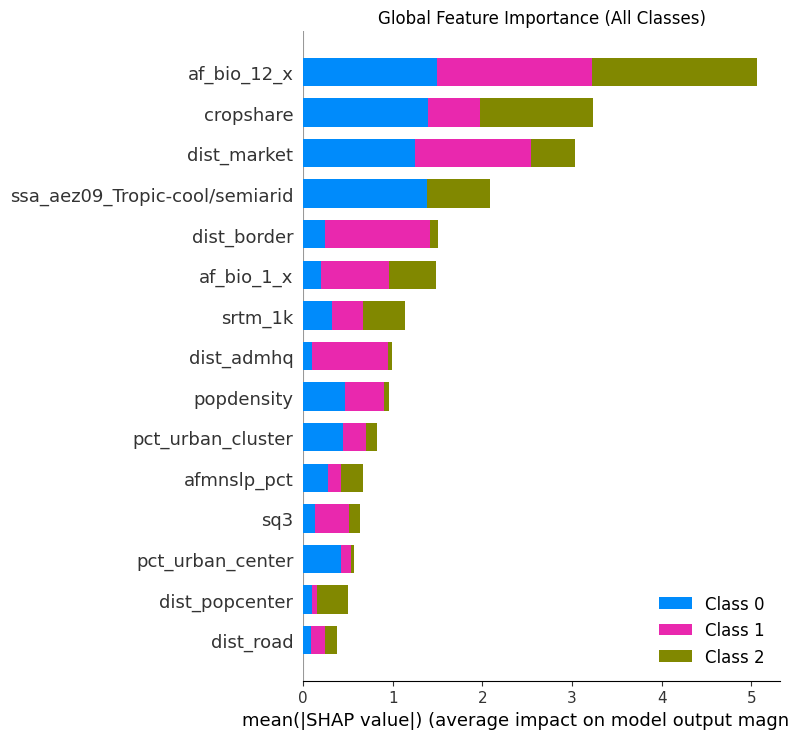

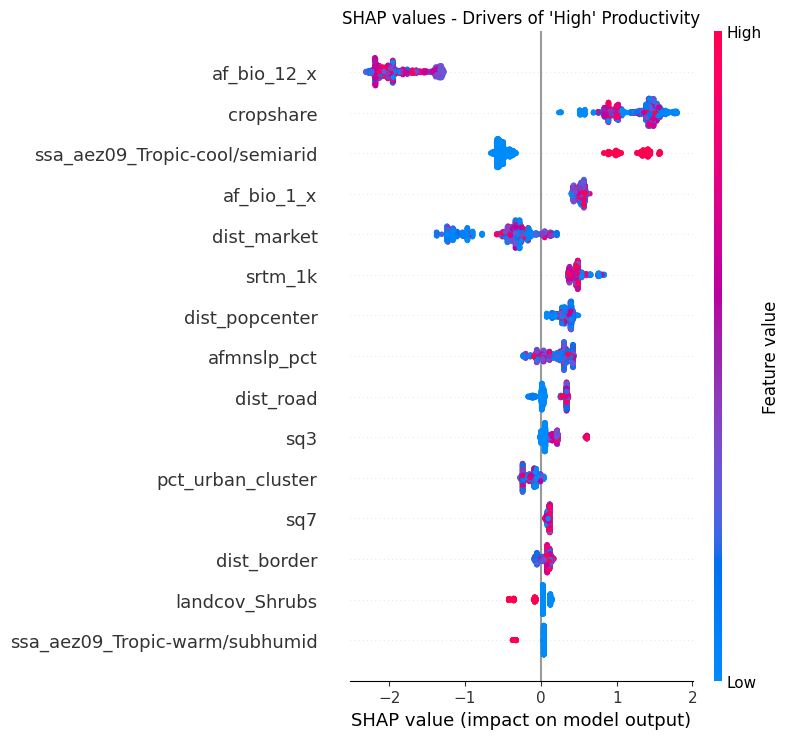

X_test shape: (978, 31)
SHAP values shape for class High: (978, 31)


In [ ]:
import shap
import matplotlib.pyplot as plt

# Fix: Use correct indexing for multiclass + match shapes
best_model = grid.best_estimator_.named_steps['classifier']

explainer = shap.TreeExplainer(best_model)

# For multiclass LightGBM → shap_values is a 3D array (n_samples, n_features, n_classes)
shap_values = explainer.shap_values(X_test)

# Option 1: Summary bar plot (absolute importance, all classes combined) - SHAP can handle 3D for this
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=15, show=False)
plt.title("Global Feature Importance (All Classes)")
plt.tight_layout()
plt.show()

# Option 2: Beeswarm for specific class (High = class index 2, check order)
class_names = ['Low', 'Medium', 'High']          # adjust according to your label order
high_class_index = 2                             # usually last for sorted labels

shap.summary_plot(
    shap_values[:, :, high_class_index],  # Correctly slice for the 'High' class
    X_test,
    feature_names=X_test.columns.tolist(),
    max_display=15,
    show=False
)
plt.title(f"SHAP values - Drivers of '{class_names[high_class_index]}' Productivity")
plt.tight_layout()
plt.show()

# Optional: Check shapes to confirm
print("X_test shape:", X_test.shape)
print("SHAP values shape for class High:", shap_values[:, :, high_class_index].shape)

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load data (Assuming df is your dataframe)
df_clean = df.dropna(subset=['lat_dd_mod', 'lon_dd_mod']).copy()

# Encoding categorical objects
le_aez = LabelEncoder()
df_clean['aez_encoded'] = le_aez.fit_transform(df_clean['ssa_aez09'])

#le_lc = LabelEncoder()
#df_clean['landcov_encoded'] = le_lc.fit_transform(df_clean['landcov'])

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Features that define the "Tropical Nature" of a site
cluster_features = ['af_bio_1_x', 'af_bio_12_x', 'srtm_1k', 'aez_encoded']

scaler = StandardScaler()
X_cluster = scaler.fit_transform(df_clean[cluster_features])

# Cluster into 7 zones (matching Ethiopia's AEZs or refining them)
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
df_clean['env_cluster'] = kmeans.fit_predict(X_cluster)

In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# 3.1 Define Target (1 = Productive for its zone, 0 = Underperforming for its zone)
df_clean['prod_label'] = df_clean.groupby('env_cluster')['evimax_avg'].transform(
    lambda x: (x >= x.median()).astype(int)
)

# 3.2 Define Input Features (Accessibility, Soil, Terrain)
# We exclude "Productivity" metrics (EVI) from inputs to avoid data leakage
X_features = [
    'dist_road', 'dist_market', 'dist_popcenter', 'afmnslp_pct',
    'sq3', 'sq4', 'sq7',
    'popdensity', 'cropshare'
]

X = df_clean[X_features]
y = df_clean['prod_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3.3 Model Training
model = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

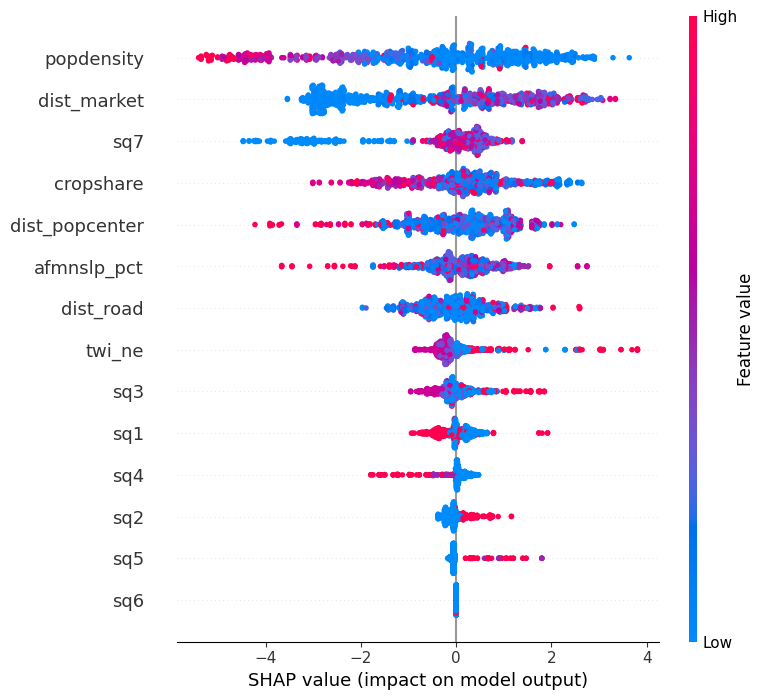

In [20]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Global importance plot
shap.summary_plot(shap_values, X_test)

In [27]:
import shap
import numpy as np # Import numpy for np.argmin

# 4.1 SHAP Drivers
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 4.2 Automated Recommendations Logic
def generate_recommendation(idx):
    # Get the feature that most negatively impacted productivity for this specific row
    row_shap = shap_values[idx]
    worst_feature_idx = np.argmin(row_shap)
    worst_feature_name = X_features[worst_feature_idx]

    rec_map = {
        'dist_market': "High Risk: Infrastructure needed. Suggest rural collection centers.",
        'sq1': "Soil Risk: Nutrient deficiency. Recommend N-P-K fertilizer subsidy.",
        'sq3': "Soil Risk: Poor drainage. Recommend specialized irrigation management.",
        'dist_road': "Market Access Risk: Prioritize feeder road construction.",
        'afmnslp_pct': "Terrain Risk: High slope. Recommend terracing and erosion control."
    }
    return rec_map.get(worst_feature_name, "General agricultural extension support required.")

df_clean['policy_recommendation'] = [generate_recommendation(i) for i in range(len(df_clean))] # Changed df_final to df_clean

In [28]:
from shapely.geometry import Point
import geopandas as gpd

# 5.1 Convert to Spatial Data
gdf = gpd.GeoDataFrame(
    df_clean, # Changed df_final to df_clean
    geometry=gpd.points_from_xy(df_clean.lon_dd_mod, df_clean.lat_dd_mod),
    crs="EPSG:4326"
)

# Add 'policy_recommendation' column based on 'prod_label'
gdf['policy_recommendation'] = gdf['prod_label'].apply(
    lambda x: 'Maintain Productivity' if x == 1 else 'Investigate for Improvement'
)

# 5.2 Create the "Risk Map" Output
# Points colored by Productivity Class, hovered for Recommendation
output_columns = ['household_id', 'ssa_aez09', 'env_cluster', 'prod_label', 'policy_recommendation', 'geometry']
gdf_output = gdf[output_columns]

# Save for use in GIS software
# gdf_output.to_file("Ethiopia_Productivity_Risk_Map.shp")

print("Pipeline Complete. Risk Map generated for", len(gdf_output), "locations.")

Pipeline Complete. Risk Map generated for 4847 locations.
